In [1]:
import os     
os.listdir("cc_17flowers/")

['17flowers']

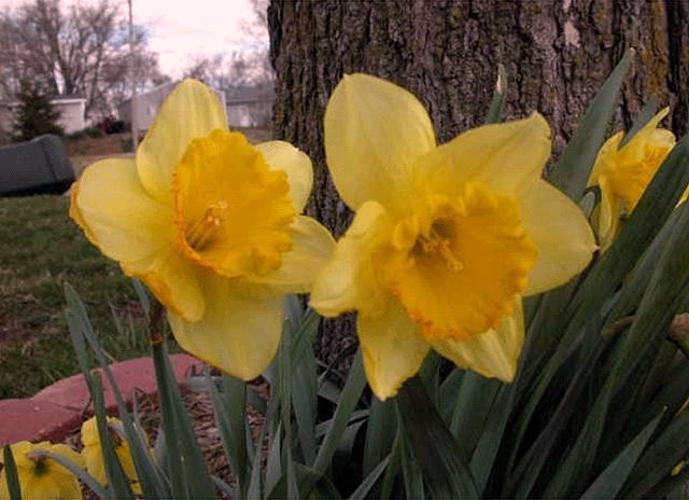

In [2]:
from PIL import Image #show one example of image
Image.open("cc_17flowers/17flowers/corrected_image_0001.jpg")

In [3]:

#load images as np arrays
import numpy as np


def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img
#all images are loaded as np arrays
images=[]
labels=[]
total=1361
j=1
for i in range(1, total): 
    fname="cc_17flowers/17flowers/corrected_image_"
    
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    images.append(load_data(fpath))
    labels.append(j) #labels are created as well
    if i%80==0: j+=1
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

In [4]:
# split data into training and test
from sklearn.model_selection import train_test_split 
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.8, random_state =  104)

c:\Users\Käyttäjä\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


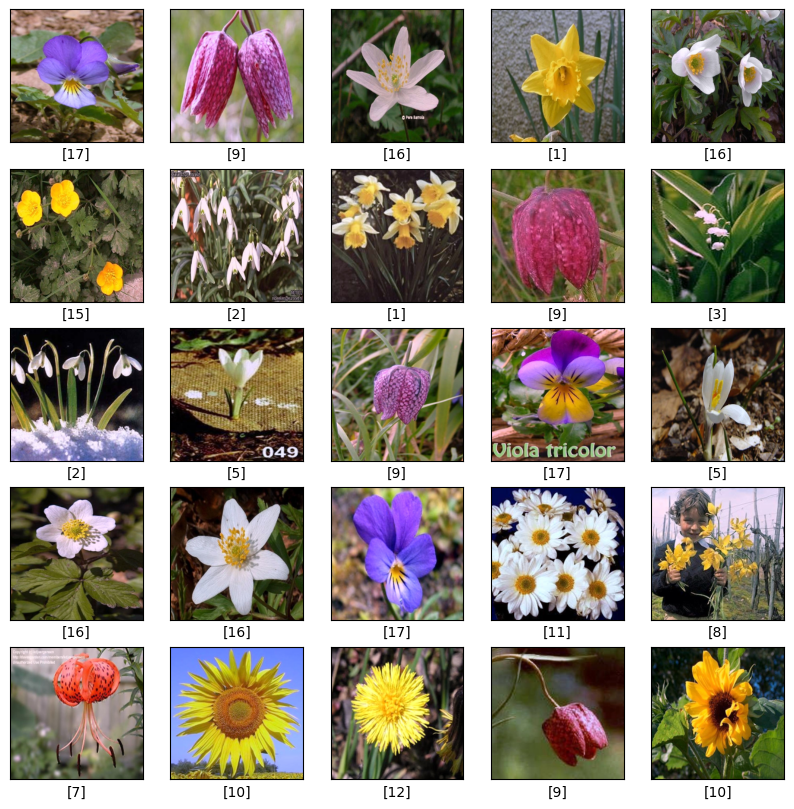

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]/255, cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [6]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np
def create_images(data, labels, folder):
    dirname=folder
    
    if not os.path.exists(dirname): #check if the folder exists; if not make dir
      os.mkdir(dirname)
    n=0
    
    for i in data:
      label_n=labels[n][0]
      subfolder = folder + "/" + str(label_n) 
      if not os.path.exists(subfolder): # create subfolders with categories
          os.mkdir(subfolder)  
      filepath =  subfolder + "/" + str(n)+ ".jpg"
      cv2.imwrite(filepath, data[n]) #save image to corresponding subfolders
      n+=1
create_images(train_images, train_labels, 'train') #save image to corresponding subfolders
create_images(test_images, test_labels, 'test')

In [7]:
train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')
image_size = 224

In [8]:
# use vgg16 pre-trained model with trainable densely connected output layer

from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers except for the last layer: 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 17)                17425     
                                                                 
Total params: 40,423,249
Trainable params: 32,787,985
Non-trainable params: 7,635,264
_________________________________________________________________


In [9]:
# image augmentation for train set and image resizing for validation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # this function will generate augmented images in real time
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255) # for validation we don't need to augment

train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory( # this function takes images from folders and feeds to Imagedatagenerator
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4), # learning rate should be small so previously learned weights don't vanish
              metrics=['acc', 'top_k_categorical_accuracy'])

c:\Users\Käyttäjä\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# train the model with augmented images in real-time
# make sure your GPU is available, otherwise training can take longer
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_17784\2818427805.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
10/10 [==============================] - 112s 10s/step - loss: 3.0065 - acc: 0.0855 - top_k_categorical_accuracy: 0.3272 - val_loss: 2.4952 - val_acc: 0.1507 - val_top_k_categorical_accuracy: 0.5625
Epoch 2/50
10/10 [==============================] - 107s 10s/step - loss: 2.5220 - acc: 0.1719 - top_k_categorical_accuracy: 0.5441 - val_loss: 2.0796 - val_acc: 0.3051 - val_top_k_categorical_accuracy: 0.6801
Epoch 3/50
10/10 [==============================] - 107s 10s/step - loss: 2.4474 - acc: 0.2353 - top_k_categorical_accuracy: 0.5938 - val_loss: 2.0362 - val_acc: 0.3382 - val_top_k_categorical_accuracy: 0.6912
Epoch 4/50
10/10 [==============================] - 107s 10s/step - loss: 2.0730 - acc: 0.3070 - top_k_categorical_accuracy: 0.7132 - val_loss: 1.7143 - val_acc: 0.4191 - val_top_k_categorical_accuracy: 0.7500
Epoch 5/50
10/10 [==============================] - 107s 10s/step - loss: 2.1281 - acc: 0.3474 - top_k_categorical_accuracy: 0.7077 - val_loss: 1.7408 - val_acc

In [12]:
model.save('my_model_vgg.h5')
print('training acc.:',history.history['acc'][-1],'\n','test acc.:', (history.history['val_acc'])[-1])


training acc.: 0.9908088445663452 
 test acc.: 0.9485294222831726


In [13]:
print(' training top 5:',history.history['top_k_categorical_accuracy'][-1], '\n',
      'val top 5:', history.history['val_top_k_categorical_accuracy'][-1], '\n')

 training top 5: 1.0 
 val top 5: 0.9926470518112183 



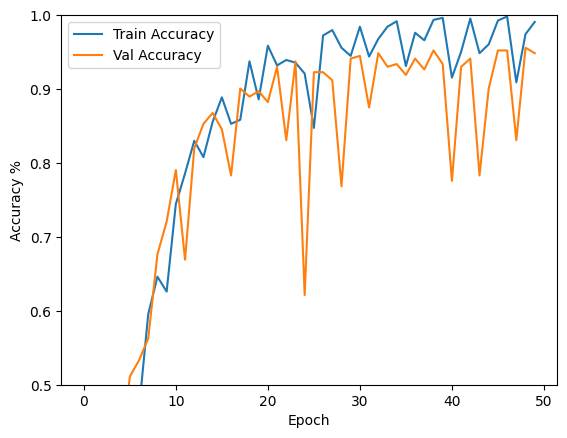

In [14]:
# plot the accuracy history
import matplotlib.pyplot as plt
def plot_history(history):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Accuracy %')
 plt.plot(history.epoch, np.array(history.history['acc']),
 label='Train Accuracy')
 plt.plot(history.epoch, np.array(history.history['val_acc']),
 label = 'Val Accuracy')
 plt.legend()
 plt.ylim([0.5, 1])
plot_history(history)